In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [32]:
import numpy as np
import random
import ast
import pandas as pd
import itertools
from itertools import product
import csv
from src.data_preprocessing import *
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
from loss_functions import *
from src.neural_network import *
from src.train_and_evaluate import *
from src.random_search import *
from src.k_fold_cross_validation import *
from src.ensemble_learning import *
# from src.data_split import *
# from src.model import *
np.random.seed(0)

ModuleNotFoundError: No module named 'data_split'

<!-- #### Data pre-processing for MONK Datasets  -->

In [ ]:
X_train, y_train = load_data(MONK_NUM=1)
X_test, y_test = load_data(MONK_NUM=1, train=False)

one hot encoded data:  (124, 17)
one hot encoded data:  (432, 17)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [ ]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Training set overlap with validation set:",
      np.intersect1d(X_train, X_val).shape[0])

Training set size: 99
Validation set size: 25
Training set overlap with validation set: 2


In [33]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (99, 17)
the shape:  (25, 17)
the shape:  (99,)
the shape:  (25,)


In [34]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
    'l1': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [2, 16, 32, 1000],
    'n_epochs': [150, 200],
    'weight_decay': list(np.arange(0.0, 0.05, 0.01))
}

TODO:

Create a seperate best_results csv file for each MONK 

In [9]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,

                                                #    X_val=X_val,
                                                #    y_val=y_val,
                                                   param_distributions=param_distributions,
                                                   n_iters=50)  # adjust n_iters as needed

print(best_hyperparams)

[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 1/5 | Validation Accuracy: 1.0000
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 2/5 | Validation Accuracy: 0.7500
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 3/5 | Validation Accuracy: 0.7500
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 4/5 | Validation Accuracy: 0.8000
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 5/5 | Validation Accuracy: 0.7368

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.8074
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 1/5 | Validation Accuracy: 0.8000
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 2/5 | Validation Accuracy: 0.5500
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [False]
✅ Fold 3/5 | Validation Accuracy: 0.8000
[3] [<class 'sr

In [35]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay, validation_accuracy = best_hyperparams.values()
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay

(0.1, 0.01, 0.001, 0.1, 16, 200, [5], ['Activation_ReLU'], [True], 0.01)

GRID SEARCH

In [ ]:
# learning_rate = 0.09
# l1 = 0.000
# l2 = 0.000
# dropout_rate = 0
# batch_size = 2
# n_epochs = 300
# hidden_size = [4]
# hidden_activation = ['Activation_Sigmoid']  # Try toggling
# use_batch_norm = [True]  # Try toggling
# weight_decay = 0.0

In [37]:
activation_map = {
    'Activation_ReLU': Activation_ReLU,
    'Activation_Tanh': Activation_Tanh,
    'Activation_ELU': Activation_ELU,
    'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
    'Activation_Sigmoid': Activation_Sigmoid
}

hidden_activation = [activation_map[act] for act in hidden_activation]  

In [38]:
model = NN(
    l1=l1,
    l2=l2,
    input_size=17,
    hidden_sizes=hidden_size,
    output_size=1,
    hidden_activations=hidden_activation,
    dropout_rates=[dropout_rate],
    use_batch_norm=use_batch_norm
)
batch_size = batch_size
learning_rate = learning_rate
n_epochs = n_epochs

[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]


### Ensemble learning

Data shapes:
X_train: (99, 17), y_train: (99,)
Sample prediction: [[0.]]
Initial loss: 1.0
Epoch 0: Train Loss: 0.5287, Acc: 58.04% | Val Loss: 0.3301, Acc: 52.00%
Epoch 10: Train Loss: 0.1891, Acc: 69.05% | Val Loss: 0.2895, Acc: 80.00%
Epoch 20: Train Loss: 0.1696, Acc: 76.49% | Val Loss: 0.2857, Acc: 76.00%
Epoch 30: Train Loss: 0.1444, Acc: 79.46% | Val Loss: 0.2963, Acc: 72.00%
Early stopping at epoch 31
Restoring model weights from epoch 1
Final Validation Accuracy: 0.7600
Test Accuracy: 0.8079


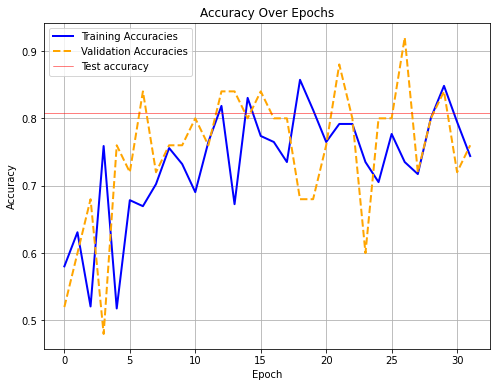

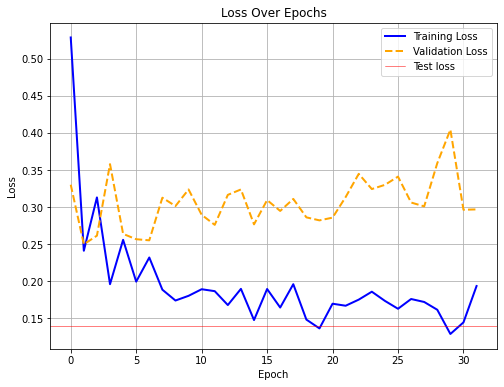

In [24]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=weight_decay)

# Initialize early stopping
early_stopping = EarlyStopping(patience=30, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Sample prediction: {model.forward(X_train[:1])}")
print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

            # Regularization
            if isinstance(layer, Layer_Dense):
                if layer.l1 > 0:
                    layer.dweights += layer.l1 * np.sign(layer.weights)
                if layer.l2 > 0:
                    layer.dweights += 2 * layer.l2 * layer.weights

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model.layers,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best weights
if early_stopping.stop_training:
    print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
    early_stopping.restore_weights(model.layers)

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training progress
plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

In [ ]:
# ensemble = EnsembleNN(n_models=5)

# ensemble.create_and_train_models(best_hyperparams)

# test_predictions = ensemble.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)

# print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
Training model 1/5
Model 1 validation accuracy: 0.8400
[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
Training model 2/5
Model 2 validation accuracy: 0.9200
[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
Training model 3/5
Model 3 validation accuracy: 0.8400
[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
Training model 4/5
Model 4 validation accuracy: 0.8800
[5] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
Training model 5/5
Model 5 validation accuracy: 0.8000
Ensemble Test Accuracy: 0.5000


c:\Users\Mostafa\Desktop\first_year_Pisa\Semester_1\ML\project_implementation\ML_project\src\loss_functions.py:24: RuntimeWarning: divide by zero encountered in log
  negative_log_likelihoods = np.log(correct_confidence)


In [17]:
print(train_losses, val_losses)

[0.26705424317689747, 0.2823012380349256, 0.3417968175393299, 0.25815783364064454, 0.3019699959065377, 0.2717091633008463, 0.2462891718103327, 0.2741333245917398, 0.2444025452441615, 0.28218130662918467, 0.27533831964440886, 0.2189622897051877, 0.23797438375664676, 0.2719872868498304, 0.2949362641569472, 0.24267923958942283, 0.2869361798034327, 0.2547486918375659, 0.22840104351899732, 0.24772777413526892, 0.290195188285327, 0.2536750146557235, 0.3305202820024686, 0.22252842480369167, 0.3178142284390356, 0.24418848143488822, 0.27997545651885203, 0.24787013282939038, 0.30081485648101697, 0.28973450881987817, 0.26750651560337546, 0.34489948663626213, 0.26977838672675164, 0.3015716798863386, 0.2985276092376456, 0.2941929267538486, 0.2637251376686227, 0.27631430478081387, 0.24904593180265805, 0.2878812040166258, 0.2877657947152416, 0.29420999969867695, 0.2948457575527174, 0.29894028650148, 0.2819772300949906, 0.3777603808836421, 0.29179800196796707, 0.2760632881436446, 0.27306523906233654, 

In [18]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5787


In [ ]:
# class EnsembleNN:
#     def __init__(self, n_models=5):
#         self.models = []
#         self.n_models = n_models
#         self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        
            

#     def create_and_train_models(self, hyperparams):
#         # Create and train multiple models with the same hyperparameters
#         for i in range(self.n_models):
#             model = NN(
#                 l1=l1,
#                 l2=l2,
#                 input_size=17,
#                 hidden_sizes=hidden_size,
#                 output_size=1,
#                 hidden_activations=hidden_activation,
#                 dropout_rates=[dropout_rate],
#                 use_batch_norm=use_batch_norm
#             )
#             print(f"Training model {i+1}/{self.n_models}")
#             # Train model using existing train_and_evaluate function
#             model, val_accuracy = train_and_evaluate(
#                 learning_rate=hyperparams['learning_rate'],
#                 # l1=hyperparams['l1'],
#                 # l2=hyperparams['l2'],
#                 # dropout_rate=hyperparams['dropout_rate'],
#                 batch_size=hyperparams['batch_size'],
#                 n_epochs=hyperparams['n_epochs'],
#                 weight_decay=hyperparams['weight_decay'],
#                 # model=hyperparams['model']
#                 # activation=hyperparams['activation']
#                 X_train=X_train,
#                 y_train=y_train,
#                 X_val=X_val,
#                 y_val=y_val,
#                 model=model,
#             )
#             self.models.append(model)
#             print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

#     def predict(self, X):
#         """Make predictions using majority voting"""
#         predictions = []
#         for model in self.models:
#             model.forward(X, training=False)
#             self.loss_activation.forward(
#                 model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
#             pred = np.argmax(self.loss_activation.output, axis=1)
#             predictions.append(pred)

#         # Majority voting
#         predictions = np.array(predictions)
#         final_predictions = np.apply_along_axis(
#             lambda x: np.bincount(x).argmax(),
#             axis=0,
#             arr=predictions
#         )
#         return final_predictions

In [ ]:
# ensemble = EnsembleNN(n_models=5)

# ensemble.create_and_train_models(best_hyperparams)

# test_predictions = ensemble.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)

# print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")